In [7]:
import torch
import torch.nn as nn
from typing import List

class Generator(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Feature extractor network."""
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Classifier(nn.Module):
    def __init__(self, input_dim: int, num_classes: int):
        """Classifier network."""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim: int):
        """Domain critic network."""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [8]:
from typing import Optional, Dict
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import trange

class WDGRL:
    def __init__(
            self,
            input_dim: int = 2, 
            hidden_dims: List[int] = [20],
            discriminator: bool = True,
            num_classes: Optional[int] = 2,
            _gamma: float = 0.1, # Gradient penalty weight 
            _lambda: float = 0.1, # Coefficient controls the balance between discriminative and transferable feature learning
            _lr_domain_critic: float = 1e-3, # Learning rate for the domain critic parameter
            _lr_feature_extractor: float = 1e-3, # Learning rate for the feature extractor (and classifier parameter if discriminator is True) 
            device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
            random_seed: Optional[int] = 0
    ):
        if random_seed is not None:
            torch.manual_seed(random_seed)
            np.random.seed(random_seed)

        self.device = device
        self._gamma = _gamma
        self._lambda = _lambda

        # Initialize networks
        self.feature_extractor = Generator(input_dim, hidden_dims).to(device)
        if discriminator:
            self.discriminator = Classifier(hidden_dims[-1], num_classes).to(device)
        self.domain_critic = Critic(hidden_dims[-1]).to(device)

        # Initialize optimizers
        if discriminator:
            self.discriminator_optimizer = torch.optim.Adam(list(self.discriminator.parameters())+list(self.feature_extractor.parameters()), lr=_lr_feature_extractor)
        self.domain_critic_optimizer = torch.optim.Adam(self.domain_critic.parameters(), lr=_lr_domain_critic)

        # Initialize loss functions
        if discriminator:
            self.classification_criterion = nn.CrossEntropyLoss()

    def compute_gradient_penalty(self, real_data: torch.Tensor, fake_data: torch.Tensor) -> torch.Tensor:
        """Compute gradient penalty."""
        alpha = torch.rand(real_data.size(0), 1).to(self.device)
        print(alpha.shape, real_data.shape, fake_data.shape)
        interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)
        
        # Domain critic outputs
        dc_output = self.domain_critic(interpolates)
        
        # Compute gradients
        gradients = torch.autograd.grad(
            outputs=dc_output,
            inputs=interpolates,
            grad_outputs=torch.ones_like(dc_output).to(self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        # Compute gradient penalty
        gradients = gradients.view(gradients.size(0), -1)
        return ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    def train(self, source_loader: DataLoader, target_loader: DataLoader, num_epochs: int = 100, dc_iter: int = 100) -> List[float]:
        """Training WDGRL."""
        self.feature_extractor.train()
        self.discriminator.train()
        self.domain_critic.train()
        critic_losses = []
        dis_losses = []
        total_losses = []
        for epoch in trange(num_epochs, desc='Epoch'):
            epoch_dc_loss = 0
            epoch_dis_loss = 0
            epoch_total_loss = 0
            for (source_data, source_labels), (target_data, _) in zip(source_loader, target_loader):
                if source_data.size(0) != target_data.size(0):
                    break
                source_data, source_labels = source_data.to(self.device), source_labels.to(self.device)
                target_data = target_data.to(self.device)

                # Train domain critic
                for __ in range(dc_iter):
                    self.domain_critic_optimizer.zero_grad()

                    with torch.no_grad():
                        source_features = self.feature_extractor(source_data)
                        target_features = self.feature_extractor(target_data)
                    
                    # Compute empirical Wasserstein distance
                    dc_source = self.domain_critic(source_features)
                    dc_target = self.domain_critic(target_features)
                    wasserstein_distance = dc_source.mean() - dc_target.mean()

                    # Gradient penalty
                    gradient_penalty = self.compute_gradient_penalty(source_features, target_features)

                    # Domain critic loss
                    dc_loss = - wasserstein_distance + self._gamma * gradient_penalty
                    dc_loss.backward()
                    self.domain_critic_optimizer.step()

                    with torch.no_grad():
                        epoch_critic_loss += dc_loss.item()
            
                # Train feature extractor and classifier
                self.discriminator_optimizer.zero_grad()
                source_features = self.feature_extractor(source_data)
        
                # Discriminator loss
                dis_loss = self.classification_criterion(self.discriminator(source_features), source_labels)
                
                with torch.no_grad():
                    batch_dis_loss += dis_loss.item()
                    target_features = self.feature_extractor(target_data)
                    dc_source = self.domain_critic(source_features)
                    dc_target = self.domain_critic(target_features)
                    wasserstein_distance = dc_source.mean() - dc_target.mean()
            
                total_loss = dis_loss + self._lambda * wasserstein_distance
                total_loss.backward()  
                self.discriminator_optimizer.step()
                dis_losses.append(total_loss.item())
        return critic_losses, dis_losses
     
    @torch.no_grad()
    def evaluate(self, data: torch.Tensor) -> torch.Tensor:
        """Evaluate accuracy."""
        self.feature_extractor.eval()
        self.discriminator.eval()
        self.domain_critic.eval()
        features = self.feature_extractor(data)
        logits = self.discriminator(features)
        return logits

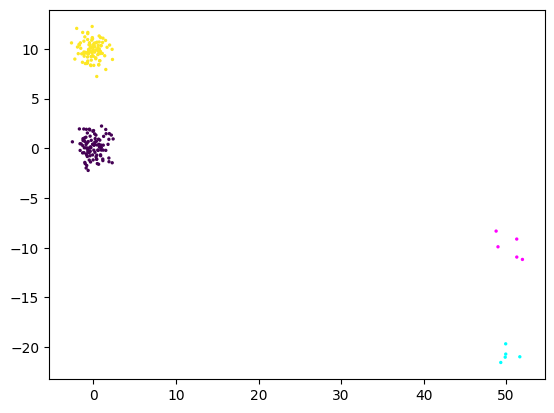

In [9]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

"""Create synthetic dataset and dataloaders for domain adaptation."""
# Create datasets
ns, nt = 200, 10

xs, ys = make_blobs(ns, centers=[[0, 0], [0, 10]], cluster_std=1)
xt, yt = make_blobs(nt, centers=[[50, -20], [50, -10]], cluster_std=1)

plt.scatter(xs[:, 0], xs[:, 1], c=ys, cmap='viridis', s=2)
plt.scatter(xt[:, 0], xt[:, 1], c=yt, cmap='cool', s=2)
plt.show()

In [10]:
# Convert to PyTorch tensors
xs = torch.FloatTensor(xs)
ys = torch.LongTensor(ys)
xt = torch.FloatTensor(xt)
yt = torch.LongTensor(yt)

In [11]:
model = WDGRL()
critic_losses, dis_losses = model.train(xs, ys, xt, 20, 100)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([200, 1]) torch.Size([200, 20]) torch.Size([10, 20])


RuntimeError: The size of tensor a (200) must match the size of tensor b (10) at non-singleton dimension 0

In [63]:
from torch.utils.data import DataLoader, TensorDataset 
source_dataset = TensorDataset(xs, ys)
target_dataset = TensorDataset(xt, yt)
batch_size = min(len(target_dataset), 64 // 2)
source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True)
print(len(source_loader))
print(len(target_loader))

20
1


In [65]:
cnt = 0
for (source_data, source_labels), (target_data, _) in zip(source_loader, target_loader):
    if source_data.size(0) != target_data.size(0):
        break
    cnt+=1
print(cnt)

1
